# Optional Lab: Multiple Variable Linear Regression

In this lab, you will extend the data structures and previously developed routines to support multiple features. Several routines are updated making the lab appear lengthy, but it makes minor adjustments to previous routines making it quick to review.
# Outline
- [&nbsp;&nbsp;1.1 Goals](#toc_15456_1.1)
- [&nbsp;&nbsp;1.2 Tools](#toc_15456_1.2)
- [&nbsp;&nbsp;1.3 Notation](#toc_15456_1.3)
- [2 Problem Statement](#toc_15456_2)
- [&nbsp;&nbsp;2.1 Matrix X containing our examples](#toc_15456_2.1)
- [&nbsp;&nbsp;2.2 Parameter vector w, b](#toc_15456_2.2)
- [3 Model Prediction With Multiple Variables](#toc_15456_3)
- [&nbsp;&nbsp;3.1 Single Prediction element by element](#toc_15456_3.1)
- [&nbsp;&nbsp;3.2 Single Prediction, vector](#toc_15456_3.2)
- [4 Compute Cost With Multiple Variables](#toc_15456_4)
- [5 Gradient Descent With Multiple Variables](#toc_15456_5)
- [&nbsp;&nbsp;5.1 Compute Gradient with Multiple Variables](#toc_15456_5.1)
- [&nbsp;&nbsp;5.2 Gradient Descent With Multiple Variables](#toc_15456_5.2)
- [6 Congratulations](#toc_15456_6)


<a name="toc_15456_1.1"></a>
## 1.1 Goals
- Extend our regression model  routines to support multiple features
    - Extend data structures to support multiple features
    - Rewrite prediction, cost and gradient routines to support multiple features
    - Utilize NumPy `np.dot` to vectorize their implementations for speed and simplicity

<a name="toc_15456_1.2"></a>
## 1.2 Tools
In this lab, we will make use of: 
- NumPy, a popular library for scientific computing
- Matplotlib, a popular library for plotting data

In [1]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays

<a name="toc_15456_1.3"></a>
## 1.3 Notation
Here is a summary of some of the notation you will encounter, updated for multiple features.  

|General <img width=70/> <br />  Notation  <img width=70/> | Description<img width=350/>| Python (if applicable) |
|: ------------|: ------------------------------------------------------------||
| $a$ | scalar, non bold                                                      ||
| $\mathbf{a}$ | vector, bold                                                 ||
| $\mathbf{A}$ | matrix, bold capital                                         ||
| **Regression** |         |    |     |
|  $\mathbf{X}$ | training example matrix                  | `X_train` |   
|  $\mathbf{y}$  | training example  targets                | `y_train` 
|  $\mathbf{x}^{(i)}$, $y^{(i)}$ | $i_{th}$Training Example | `X[i]`, `y[i]`|
| m | number of training examples | `m`|
| n | number of features in each example | `n`|
|  $\mathbf{w}$  |  parameter: weight,                       | `w`    |
|  $b$           |  parameter: bias                                           | `b`    |     
| $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ | The result of the model evaluation at $\mathbf{x^{(i)}}$ parameterized by $\mathbf{w},b$: $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)}+b$  | `f_wb` | 


<a name="toc_15456_2"></a>
# 2 Problem Statement

You will use the motivating example of housing price prediction. The training dataset contains three examples with four features (size, bedrooms, floors and, age) shown in the table below.  Note that, unlike the earlier labs, size is in sqft rather than 1000 sqft. This causes an issue, which you will solve in the next lab!

| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|-------------- |  
| 2104            | 5                   | 1                | 45           | 460           |  
| 1416            | 3                   | 2                | 40           | 232           |  
| 852             | 2                   | 1                | 35           | 178           |  

You will build a linear regression model using these values so you can then predict the price for other houses. For example, a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old.  

Please run the following code cell to create your `X_train` and `y_train` variables.

In [2]:
X_train = np.array([[2104, 5, 1, 45], [1416, 3, 2, 40], [852, 2, 1, 35]])
y_train = np.array([460, 232, 178])

<a name="toc_15456_2.1"></a>
## 2.1 Matrix X containing our examples
Similar to the table above, examples are stored in a NumPy matrix `X_train`. Each row of the matrix represents one example. When you have $m$ training examples ( $m$ is three in our example), and there are $n$ features (four in our example), $\mathbf{X}$ is a matrix with dimensions ($m$, $n$) (m rows, n columns).


$$\mathbf{X} = 
\begin{pmatrix}
 x^{(0)}_0 & x^{(0)}_1 & \cdots & x^{(0)}_{n-1} \\ 
 x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_{n-1} \\
 \cdots \\
 x^{(m-1)}_0 & x^{(m-1)}_1 & \cdots & x^{(m-1)}_{n-1} 
\end{pmatrix}
$$
notation:
- $\mathbf{x}^{(i)}$ is vector containing example i. $\mathbf{x}^{(i)}$ $ = (x^{(i)}_0, x^{(i)}_1, \cdots,x^{(i)}_{n-1})$
- $x^{(i)}_j$ is element j in example i. The superscript in parenthesis indicates the example number while the subscript represents an element.  

Display the input data.

In [3]:
# data is stored in numpy array/matrix
print(f"X Shape: {X_train.shape}, X Type:{type(X_train)})")
print(X_train)
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")
print(y_train)

X Shape: (3, 4), X Type:<class 'numpy.ndarray'>)
[[2104    5    1   45]
 [1416    3    2   40]
 [ 852    2    1   35]]
y Shape: (3,), y Type:<class 'numpy.ndarray'>)
[460 232 178]


<a name="toc_15456_2.2"></a>
## 2.2 Parameter vector w, b

* $\mathbf{w}$ is a vector with $n$ elements.
  - Each element contains the parameter associated with one feature.
  - in our dataset, n is 4.
  - notionally, we draw this as a column vector

$$\mathbf{w} = \begin{pmatrix}
w_0 \\ 
w_1 \\
\cdots\\
w_{n-1}
\end{pmatrix}
$$
* $b$ is a scalar parameter.  

For demonstration, $\mathbf{w}$ and $b$ will be loaded with some initial selected values that are near the optimal. $\mathbf{w}$ is a 1-D NumPy vector.

In [9]:
b_init = 785.1811367994083
w_init = np.array([ 0.39133535, 18.75376741, -53.36032453, -26.42131618])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")

w_init shape: (4,), b_init type: <class 'float'>


<a name="toc_15456_3"></a>
# 3 Model Prediction With Multiple Variables
The model's prediction with multiple variables is given by the linear model:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
where $\cdot$ is a vector `dot product`

To demonstrate the dot product, we will implement prediction using (1) and (2).

<a name="toc_15456_3.1"></a>
## 3.1 Single Prediction element by element
Our previous prediction multiplied one feature value by one parameter and added a bias parameter. A direct extension of our previous implementation of prediction to multiple features would be to implement (1) above using loop over each element, performing the multiply with its parameter and then adding the bias parameter at the end.


In [5]:
def predict_single_loop(x, w, b): 
    """
    single predict using linear regression
    
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters    
      b (scalar):  model parameter     
      
    Returns:
      p (scalar):  prediction
    """
    n = x.shape[0]
    p = 0
    for i in range(n):
        p_i = x[i] * w[i]  
        p = p + p_i         
    p = p + b                
    return p

In [6]:
# get a row from our training data
x_vec = X_train[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")

# make a prediction
f_wb = predict_single_loop(x_vec, w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb}")

x_vec shape (4,), x_vec value: [2104    5    1   45]
f_wb shape (), prediction: 459.9999976194083


Note the shape of `x_vec`. It is a 1-D NumPy vector with 4 elements, (4,). The result, `f_wb` is a scalar.

<a name="toc_15456_3.2"></a>
## 3.2 Single Prediction, vector

Noting that equation (1) above can be implemented using the dot product as in (2) above. We can make use of vector operations to speed up predictions.

Recall from the Python/Numpy lab that NumPy `np.dot()`[[link](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)] can be used to perform a vector dot product. 

In [10]:
def predict(x, w, b): 
    """
    single predict using linear regression
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters   
      b (scalar):             model parameter 
      
    Returns:
      p (scalar):  prediction
    """
    p = np.dot(x, w) + b     
    return p    

In [11]:
# get a row from our training data
x_vec = X_train[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")

# make a prediction
f_wb = predict(x_vec,w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb}")

x_vec shape (4,), x_vec value: [2104    5    1   45]
f_wb shape (), prediction: 459.99999761940825


The results and shapes are the same as the previous version which used looping. Going forward, `np.dot` will be used for these operations. The prediction is now a single statement. Most routines will implement it directly rather than calling a separate predict routine.

<a name="toc_15456_4"></a>
# 4 Compute Cost With Multiple Variables
The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 


In contrast to previous labs, $\mathbf{w}$ and $\mathbf{x}^{(i)}$ are vectors rather than scalars supporting multiple features.

Below is an implementation of equations (3) and (4). Note that this uses a *standard pattern for this course* where a for loop over all `m` examples is used.

In [12]:
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

In [13]:
# Compute and display cost using our pre-chosen optimal parameters. 
cost = compute_cost(X_train, y_train, w_init, b_init)
print(f'Cost at optimal w : {cost}')

Cost at optimal w : 1.5578904880036537e-12


**Expected Result**: Cost at optimal w : 1.5578904045996674e-12

<a name="toc_15456_5"></a>
# 5 Gradient Descent With Multiple Variables
Gradient descent for multiple variables:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


<a name="toc_15456_5.1"></a>
## 5.1 Compute Gradient with Multiple Variables
An implementation for calculating the equations (6) and (7) is below. There are many ways to implement this. In this version, there is an
- outer loop over all m examples. 
    - $\frac{\partial J(\mathbf{w},b)}{\partial b}$ for the example can be computed directly and accumulated
    - in a second loop over all n features:
        - $\frac{\partial J(\mathbf{w},b)}{\partial w_j}$ is computed for each $w_j$.
   

In [27]:
def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err       
        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

In [37]:
#Compute and display gradient 
#print(X_train, y_train, w_init, b_init)
tmp_dj_db, tmp_dj_dw = compute_gradient(X_train, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

dj_db at initial w,b: -1.673925169143331e-06
dj_dw at initial w,b: 
 [-2.73e-03 -6.27e-06 -2.22e-06 -6.92e-05]


**Expected Result**:   
dj_db at initial w,b: -1.6739251122999121e-06  
dj_dw at initial w,b:   
 [-2.73e-03 -6.27e-06 -2.22e-06 -6.92e-05]  

<a name="toc_15456_5.2"></a>
## 5.2 Gradient Descent With Multiple Variables
The routine below implements equation (5) above.

In [33]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None
        print(f"{i:5d}  w={w}, b={b}, cost={cost_function(X,y,w,b)}")
        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
        
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

In the next cell you will test the implementation. 

In [36]:
# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 9000
alpha = 5.0e-7
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.9f},{w_final} ")
m,_ = X_train.shape
for i in range(m):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

    0  w=[0. 0. 0. 0.], b=0.0, cost=49518.0
Iteration    0: Cost  2529.46   
    1  w=[2.41e-01 5.59e-04 1.84e-04 6.03e-03], b=0.000145, cost=2529.4629522316304
    2  w=[1.95e-01 4.54e-04 1.34e-04 4.78e-03], b=0.00011402564683333336, cost=765.8336829952988
    3  w=[2.04e-01 4.79e-04 1.30e-04 4.94e-03], b=0.00011714368908454539, cost=699.6290280210446
    4  w=[2.02e-01 4.78e-04 1.17e-04 4.82e-03], b=0.00011365700305146083, cost=697.1337425623095
    5  w=[2.02e-01 4.82e-04 1.06e-04 4.75e-03], b=0.00011145001540926669, cost=697.0296591788104
    6  w=[2.02e-01 4.85e-04 9.45e-05 4.68e-03], b=0.00010899524267421966, cost=697.0153256006653
    7  w=[2.02e-01 4.88e-04 8.30e-05 4.61e-03], b=0.00010658861070525292, cost=697.0043615139087
    8  w=[2.02e-01 4.92e-04 7.15e-05 4.54e-03], b=0.00010417278852237808, cost=696.9935248096691
    9  w=[2.02e-01 4.95e-04 6.00e-05 4.46e-03], b=0.00010175888309386385, cost=696.9826938019223
   10  w=[2.02e-01 4.98e-04 4.86e-05 4.39e-03], b=9.93447426134

  320  w=[ 0.2   0.   -0.   -0.02], b=-0.0006435430512012659, cost=693.6600289832008
  321  w=[ 0.2   0.   -0.   -0.02], b=-0.0006459218734804289, cost=693.6494908287809
  322  w=[ 0.2   0.   -0.   -0.02], b=-0.0006483005831632956, cost=693.6389535994064
  323  w=[ 0.2   0.   -0.   -0.02], b=-0.0006506791802548737, cost=693.6284172949946
  324  w=[ 0.2   0.   -0.   -0.02], b=-0.0006530576647601703, cost=693.6178819154626
  325  w=[ 0.2   0.   -0.   -0.02], b=-0.0006554360366841926, cost=693.6073474607274
  326  w=[ 0.2   0.   -0.   -0.02], b=-0.0006578142960319475, cost=693.5968139307097
  327  w=[ 0.2   0.   -0.   -0.02], b=-0.0006601924428084416, cost=693.5862813253265
  328  w=[ 0.2   0.   -0.   -0.02], b=-0.0006625704770186813, cost=693.575749644492
  329  w=[ 0.2   0.   -0.   -0.02], b=-0.0006649483986676729, cost=693.5652188881276
  330  w=[ 0.2   0.   -0.   -0.02], b=-0.0006673262077604224, cost=693.5546890561482
  331  w=[ 0.2   0.   -0.   -0.02], b=-0.0006697039043019354, cost

  537  w=[ 0.2   0.   -0.01 -0.03], b=-0.0011571170695791227, cost=691.3947913109808
  538  w=[ 0.2   0.   -0.01 -0.03], b=-0.001159471575445677, cost=691.3844519755972
  539  w=[ 0.2   0.   -0.01 -0.03], b=-0.0011618259697973702, cost=691.3741135475793
  540  w=[ 0.2   0.   -0.01 -0.03], b=-0.0011641802526391617, cost=691.3637760268448
  541  w=[ 0.2   0.   -0.01 -0.03], b=-0.0011665344239760104, cost=691.3534394133125
  542  w=[ 0.2   0.   -0.01 -0.03], b=-0.0011688884838128757, cost=691.3431037069046
  543  w=[ 0.2   0.   -0.01 -0.03], b=-0.0011712424321547164, cost=691.3327689075354
  544  w=[ 0.2   0.   -0.01 -0.03], b=-0.0011735962690064908, cost=691.3224350151298
  545  w=[ 0.2   0.   -0.01 -0.03], b=-0.0011759499943731573, cost=691.3121020296018
  546  w=[ 0.2   0.   -0.01 -0.03], b=-0.0011783036082596743, cost=691.3017699508749
  547  w=[ 0.2   0.   -0.01 -0.03], b=-0.0011806571106709994, cost=691.2914387788655
  548  w=[ 0.2   0.   -0.01 -0.03], b=-0.0011830105016120904, cost

  782  w=[ 0.2   0.   -0.01 -0.05], b=-0.0017306498027379478, cost=688.8885809490588
  783  w=[ 0.2   0.   -0.01 -0.05], b=-0.0017329771351691423, cost=688.8784615233827
  784  w=[ 0.2   0.   -0.01 -0.05], b=-0.0017353043572939742, cost=688.8683429855142
  785  w=[ 0.2   0.   -0.01 -0.05], b=-0.0017376314691173492, cost=688.8582253353769
  786  w=[ 0.2   0.   -0.01 -0.05], b=-0.001739958470644173, cost=688.8481085728882
  787  w=[ 0.2   0.   -0.01 -0.05], b=-0.0017422853618793506, cost=688.8379926979718
  788  w=[ 0.2   0.   -0.01 -0.05], b=-0.0017446121428277873, cost=688.8278777105476
  789  w=[ 0.2   0.   -0.01 -0.05], b=-0.001746938813494388, cost=688.8177636105369
  790  w=[ 0.2   0.   -0.01 -0.05], b=-0.0017492653738840572, cost=688.8076503978587
  791  w=[ 0.2   0.   -0.01 -0.05], b=-0.0017515918240016994, cost=688.7975380724403
  792  w=[ 0.2   0.   -0.01 -0.05], b=-0.0017539181638522186, cost=688.7874266341963
  793  w=[ 0.2   0.   -0.01 -0.05], b=-0.001756244393440519, cost=6

  981  w=[ 0.2   0.   -0.01 -0.06], b=-0.002191622143616338, cost=686.8922042552081
  982  w=[ 0.2   0.   -0.01 -0.06], b=-0.0021939276214473545, cost=686.8822599570149
  983  w=[ 0.2   0.   -0.01 -0.06], b=-0.0021962329899439617, cost=686.8723165310561
  984  w=[ 0.2   0.   -0.01 -0.06], b=-0.0021985382491110216, cost=686.8623739772542
  985  w=[ 0.2   0.   -0.01 -0.06], b=-0.002200843398953397, cost=686.8524322955327
  986  w=[ 0.2   0.   -0.01 -0.06], b=-0.0022031484394759494, cost=686.8424914858106
  987  w=[ 0.2   0.   -0.01 -0.06], b=-0.0022054533706835407, cost=686.8325515480159
  988  w=[ 0.2   0.   -0.01 -0.07], b=-0.002207758192581033, cost=686.8226124820654
  989  w=[ 0.2   0.   -0.01 -0.07], b=-0.002210062905173287, cost=686.8126742878859
  990  w=[ 0.2   0.   -0.01 -0.07], b=-0.0022123675084651647, cost=686.8027369653997
  991  w=[ 0.2   0.   -0.01 -0.07], b=-0.0022146720024615266, cost=686.7928005145255
  992  w=[ 0.2   0.   -0.01 -0.07], b=-0.002216976387167234, cost=686

 1212  w=[ 0.2   0.   -0.01 -0.08], b=-0.0027212928892002505, cost=684.6180857929377
 1213  w=[ 0.2   0.   -0.01 -0.08], b=-0.0027235732395176006, cost=684.6083409343365
 1214  w=[ 0.2   0.   -0.01 -0.08], b=-0.002725853481618054, cost=684.598596930232
 1215  w=[ 0.2   0.   -0.01 -0.08], b=-0.0027281336155064234, cost=684.5888537805563
 1216  w=[ 0.2   0.   -0.01 -0.08], b=-0.0027304136411875216, cost=684.5791114852228
 1217  w=[ 0.2   0.   -0.01 -0.08], b=-0.002732693558666161, cost=684.569370044163
 1218  w=[ 0.2   0.   -0.01 -0.08], b=-0.0027349733679471536, cost=684.5596294572965
 1219  w=[ 0.2   0.   -0.01 -0.08], b=-0.0027372530690353116, cost=684.5498897245494
 1220  w=[ 0.2   0.   -0.01 -0.08], b=-0.0027395326619354464, cost=684.540150845847
 1221  w=[ 0.2   0.   -0.01 -0.08], b=-0.0027418121466523697, cost=684.5304128211104
 1222  w=[ 0.2   0.   -0.01 -0.08], b=-0.0027440915231908927, cost=684.520675650267
 1223  w=[ 0.2   0.   -0.01 -0.08], b=-0.0027463707915558267, cost=684.

 1427  w=[ 0.2   0.01 -0.02 -0.1 ], b=-0.0032090865202542207, cost=682.5424754110882
 1428  w=[ 0.2   0.01 -0.02 -0.1 ], b=-0.003211343714308694, cost=682.5329125326575
 1429  w=[ 0.2   0.01 -0.02 -0.1 ], b=-0.0032136008011761164, cost=682.523350492542
 1430  w=[ 0.2   0.01 -0.02 -0.1 ], b=-0.003215857780861255, cost=682.5137892906679
 1431  w=[ 0.2   0.01 -0.02 -0.1 ], b=-0.0032181146533688766, cost=682.5042289269624
 1432  w=[ 0.2   0.01 -0.02 -0.1 ], b=-0.003220371418703748, cost=682.4946694013463
 1433  w=[ 0.2   0.01 -0.02 -0.1 ], b=-0.0032226280768706352, cost=682.48511071375
 1434  w=[ 0.2   0.01 -0.02 -0.1 ], b=-0.0032248846278743045, cost=682.475552864096
 1435  w=[ 0.2   0.01 -0.02 -0.1 ], b=-0.003227141071719522, cost=682.4659958523138
 1436  w=[ 0.2   0.01 -0.02 -0.1 ], b=-0.0032293974084110534, cost=682.4564396783225
 1437  w=[ 0.2   0.01 -0.02 -0.1 ], b=-0.003231653637953664, cost=682.4468843420518
 1438  w=[ 0.2   0.01 -0.02 -0.1 ], b=-0.0032339097603521195, cost=682.437

 1659  w=[ 0.21  0.01 -0.02 -0.11], b=-0.003729893124961955, cost=680.3461987580862
 1660  w=[ 0.21  0.01 -0.02 -0.11], b=-0.003732125578923194, cost=680.3368283849162
 1661  w=[ 0.21  0.01 -0.02 -0.11], b=-0.0037343579267976683, cost=680.3274588329413
 1662  w=[ 0.21  0.01 -0.02 -0.11], b=-0.003736590168590097, cost=680.3180901020913
 1663  w=[ 0.21  0.01 -0.02 -0.11], b=-0.003738822304305197, cost=680.3087221922922
 1664  w=[ 0.21  0.01 -0.02 -0.11], b=-0.0037410543339476865, cost=680.2993551034725
 1665  w=[ 0.21  0.01 -0.02 -0.11], b=-0.0037432862575222828, cost=680.2899888355552
 1666  w=[ 0.21  0.01 -0.02 -0.11], b=-0.0037455180750337034, cost=680.2806233884714
 1667  w=[ 0.21  0.01 -0.02 -0.11], b=-0.003747749786486665, cost=680.2712587621471
 1668  w=[ 0.21  0.01 -0.02 -0.11], b=-0.0037499813918858847, cost=680.2618949565095
 1669  w=[ 0.21  0.01 -0.02 -0.11], b=-0.0037522128912360793, cost=680.2525319714833
 1670  w=[ 0.21  0.01 -0.02 -0.11], b=-0.0037544442845419647, cost=680

 1894  w=[ 0.21  0.01 -0.02 -0.13], b=-0.004251612999558728, cost=678.1665847345934
 1895  w=[ 0.21  0.01 -0.02 -0.13], b=-0.004253820652407369, cost=678.1574053486759
 1896  w=[ 0.21  0.01 -0.02 -0.13], b=-0.004256028200272247, cost=678.1482267669716
 1897  w=[ 0.21  0.01 -0.02 -0.13], b=-0.004258235643158033, cost=678.1390489894115
 1898  w=[ 0.21  0.01 -0.02 -0.13], b=-0.004260442981069395, cost=678.1298720159208
 1899  w=[ 0.21  0.01 -0.02 -0.13], b=-0.004262650214011001, cost=678.1206958464282
 1900  w=[ 0.21  0.01 -0.02 -0.13], b=-0.004264857341987521, cost=678.1115204808616
 1901  w=[ 0.21  0.01 -0.02 -0.13], b=-0.004267064365003622, cost=678.1023459191534
 1902  w=[ 0.21  0.01 -0.02 -0.13], b=-0.004269271283063972, cost=678.093172161227
 1903  w=[ 0.21  0.01 -0.02 -0.13], b=-0.004271478096173239, cost=678.0839992070152
 1904  w=[ 0.21  0.01 -0.02 -0.13], b=-0.004273684804336091, cost=678.0748270564437
 1905  w=[ 0.21  0.01 -0.02 -0.13], b=-0.004275891407557194, cost=678.0656557

 2130  w=[ 0.21  0.01 -0.02 -0.14], b=-0.004769717944875164, cost=676.0223966032132
 2131  w=[ 0.21  0.01 -0.02 -0.14], b=-0.004771900950580641, cost=676.0134050421533
 2132  w=[ 0.21  0.01 -0.02 -0.14], b=-0.004774083852398513, cost=676.004414268604
 2133  w=[ 0.21  0.01 -0.02 -0.14], b=-0.0047762666503333995, cost=675.9954242824966
 2134  w=[ 0.21  0.01 -0.02 -0.14], b=-0.004778449344389922, cost=675.986435083758
 2135  w=[ 0.21  0.01 -0.02 -0.14], b=-0.004780631934572698, cost=675.97744667232
 2136  w=[ 0.21  0.01 -0.02 -0.14], b=-0.00478281442088635, cost=675.9684590481122
 2137  w=[ 0.21  0.01 -0.02 -0.14], b=-0.004784996803335496, cost=675.9594722110647
 2138  w=[ 0.21  0.01 -0.02 -0.14], b=-0.004787179081924755, cost=675.950486161109
 2139  w=[ 0.21  0.01 -0.02 -0.14], b=-0.004789361256658747, cost=675.9415008981712
 2140  w=[ 0.21  0.01 -0.02 -0.14], b=-0.00479154332754209, cost=675.9325164221858
 2141  w=[ 0.21  0.01 -0.02 -0.14], b=-0.004793725294579404, cost=675.923532733081

 2350  w=[ 0.21  0.01 -0.03 -0.16], b=-0.005247484616217801, cost=674.0631022958368
 2351  w=[ 0.21  0.01 -0.03 -0.16], b=-0.0052496448775943855, cost=674.0542823108993
 2352  w=[ 0.21  0.01 -0.03 -0.16], b=-0.005251805036094898, cost=674.0454630982126
 2353  w=[ 0.21  0.01 -0.03 -0.16], b=-0.005253965091723913, cost=674.0366446577106
 2354  w=[ 0.21  0.01 -0.03 -0.16], b=-0.005256125044486006, cost=674.0278269893239
 2355  w=[ 0.21  0.01 -0.03 -0.16], b=-0.005258284894385752, cost=674.0190100929859
 2356  w=[ 0.21  0.01 -0.03 -0.16], b=-0.0052604446414277264, cost=674.010193968622
 2357  w=[ 0.21  0.01 -0.03 -0.16], b=-0.005262604285616502, cost=674.0013786161709
 2358  w=[ 0.21  0.01 -0.03 -0.16], b=-0.005264763826956655, cost=673.9925640355585
 2359  w=[ 0.21  0.01 -0.03 -0.16], b=-0.005266923265452758, cost=673.9837502267186
 2360  w=[ 0.21  0.01 -0.03 -0.16], b=-0.005269082601109385, cost=673.9749371895837
 2361  w=[ 0.21  0.01 -0.03 -0.16], b=-0.00527124183393111, cost=673.966124

 2586  w=[ 0.21  0.01 -0.03 -0.17], b=-0.005754463418167604, cost=672.0028526488402
 2587  w=[ 0.21  0.01 -0.03 -0.17], b=-0.005756599527225833, cost=671.9942130243713
 2588  w=[ 0.21  0.01 -0.03 -0.17], b=-0.005758735534482143, cost=671.9855741561195
 2589  w=[ 0.21  0.01 -0.03 -0.17], b=-0.005760871439941062, cost=671.9769360440117
 2590  w=[ 0.21  0.01 -0.03 -0.17], b=-0.005763007243607117, cost=671.9682986879844
 2591  w=[ 0.21  0.01 -0.03 -0.17], b=-0.005765142945484835, cost=671.9596620879694
 2592  w=[ 0.21  0.01 -0.03 -0.17], b=-0.0057672785455787435, cost=671.9510262438988
 2593  w=[ 0.21  0.01 -0.03 -0.17], b=-0.005769414043893369, cost=671.9423911557077
 2594  w=[ 0.21  0.01 -0.03 -0.17], b=-0.005771549440433238, cost=671.9337568233256
 2595  w=[ 0.21  0.01 -0.03 -0.17], b=-0.005773684735202876, cost=671.925123246687
 2596  w=[ 0.21  0.01 -0.03 -0.17], b=-0.0057758199282068115, cost=671.9164904257243
 2597  w=[ 0.21  0.01 -0.03 -0.17], b=-0.005777955019449568, cost=671.90785

 2817  w=[ 0.21  0.01 -0.03 -0.19], b=-0.006245209400381067, cost=670.0270525437579
 2818  w=[ 0.21  0.01 -0.03 -0.19], b=-0.006247322113063406, cost=670.0185858303381
 2819  w=[ 0.21  0.01 -0.03 -0.19], b=-0.006249434724984363, cost=670.0101198577569
 2820  w=[ 0.21  0.01 -0.03 -0.19], b=-0.006251547236148418, cost=670.001654625947
 2821  w=[ 0.21  0.01 -0.03 -0.19], b=-0.006253659646560052, cost=669.9931901348431
 2822  w=[ 0.21  0.01 -0.03 -0.19], b=-0.006255771956223746, cost=669.9847263843791
 2823  w=[ 0.21  0.01 -0.03 -0.19], b=-0.006257884165143981, cost=669.9762633744889
 2824  w=[ 0.21  0.01 -0.03 -0.19], b=-0.006259996273325238, cost=669.9678011051064
 2825  w=[ 0.21  0.01 -0.03 -0.19], b=-0.006262108280771996, cost=669.9593395761661
 2826  w=[ 0.21  0.01 -0.03 -0.19], b=-0.0062642201874887355, cost=669.9508787876033
 2827  w=[ 0.21  0.01 -0.03 -0.19], b=-0.006266331993479937, cost=669.9424187393503
 2828  w=[ 0.21  0.01 -0.03 -0.19], b=-0.00626844369875008, cost=669.9339594

 3046  w=[ 0.21  0.01 -0.03 -0.2 ], b=-0.006726398957906051, cost=668.1073859894776
 3047  w=[ 0.21  0.01 -0.03 -0.2 ], b=-0.006728488712827549, cost=668.099087219495
 3048  w=[ 0.21  0.01 -0.03 -0.2 ], b=-0.006730578368008694, cost=668.0907891754173
 3049  w=[ 0.21  0.01 -0.03 -0.2 ], b=-0.006732667923453922, cost=668.082491857176
 3050  w=[ 0.21  0.01 -0.03 -0.2 ], b=-0.0067347573791676696, cost=668.0741952647106
 3051  w=[ 0.21  0.01 -0.03 -0.2 ], b=-0.006736846735154372, cost=668.0658993979526
 3052  w=[ 0.21  0.01 -0.03 -0.2 ], b=-0.0067389359914184635, cost=668.0576042568391
 3053  w=[ 0.21  0.01 -0.03 -0.2 ], b=-0.00674102514796438, cost=668.049309841305
 3054  w=[ 0.21  0.01 -0.03 -0.2 ], b=-0.006743114204796556, cost=668.041016151289
 3055  w=[ 0.21  0.01 -0.03 -0.2 ], b=-0.006745203161919427, cost=668.0327231867242
 3056  w=[ 0.21  0.01 -0.03 -0.2 ], b=-0.006747292019337427, cost=668.0244309475448
 3057  w=[ 0.21  0.01 -0.03 -0.2 ], b=-0.00674938077705499, cost=668.0161394336

 3269  w=[ 0.21  0.01 -0.04 -0.22], b=-0.007189953501420536, cost=666.2746114220528
 3270  w=[ 0.21  0.01 -0.04 -0.22], b=-0.007192021123686126, cost=666.2664729409713
 3271  w=[ 0.21  0.01 -0.04 -0.22], b=-0.0071940886471957, cost=666.2583351715404
 3272  w=[ 0.21  0.01 -0.04 -0.22], b=-0.00719615607195365, cost=666.2501981136925
 3273  w=[ 0.21  0.01 -0.04 -0.22], b=-0.007198223397964367, cost=666.2420617673685
 3274  w=[ 0.21  0.01 -0.04 -0.22], b=-0.007200290625232244, cost=666.233926132503
 3275  w=[ 0.21  0.01 -0.04 -0.22], b=-0.007202357753761672, cost=666.2257912090337
 3276  w=[ 0.21  0.01 -0.04 -0.22], b=-0.007204424783557043, cost=666.2176569968973
 3277  w=[ 0.21  0.01 -0.04 -0.22], b=-0.007206491714622747, cost=666.2095234960292
 3278  w=[ 0.21  0.01 -0.04 -0.22], b=-0.007208558546963176, cost=666.2013907063684
 3279  w=[ 0.21  0.01 -0.04 -0.22], b=-0.007210625280582719, cost=666.1932586278491
 3280  w=[ 0.21  0.01 -0.04 -0.22], b=-0.007212691915485769, cost=666.1851272604

 3494  w=[ 0.21  0.01 -0.04 -0.23], b=-0.007652688066619049, cost=664.4612687703361
 3495  w=[ 0.21  0.01 -0.04 -0.23], b=-0.007654733579097406, cost=664.4532888259871
 3496  w=[ 0.21  0.01 -0.04 -0.23], b=-0.007656778993803067, cost=664.4453095791895
 3497  w=[ 0.21  0.01 -0.04 -0.23], b=-0.007658824310740381, cost=664.4373310298814
 3498  w=[ 0.21  0.01 -0.04 -0.23], b=-0.007660869529913697, cost=664.4293531779988
 3499  w=[ 0.21  0.01 -0.04 -0.23], b=-0.0076629146513273625, cost=664.421376023481
 3500  w=[ 0.21  0.01 -0.04 -0.23], b=-0.007664959674985725, cost=664.4133995662673
 3501  w=[ 0.21  0.01 -0.04 -0.23], b=-0.007667004600893132, cost=664.4054238062957
 3502  w=[ 0.21  0.01 -0.04 -0.23], b=-0.007669049429053931, cost=664.3974487434994
 3503  w=[ 0.21  0.01 -0.04 -0.23], b=-0.00767109415947247, cost=664.3894743778206
 3504  w=[ 0.21  0.01 -0.04 -0.23], b=-0.007673138792153095, cost=664.3815007091973
 3505  w=[ 0.21  0.01 -0.04 -0.23], b=-0.007675183327100154, cost=664.3735277

 3717  w=[ 0.21  0.01 -0.04 -0.24], b=-0.008106425091582442, cost=662.6988950962136
 3718  w=[ 0.21  0.01 -0.04 -0.24], b=-0.008108448908033817, cost=662.6910691802619
 3719  w=[ 0.21  0.01 -0.04 -0.24], b=-0.00811047262767742, cost=662.6832439481652
 3720  w=[ 0.21  0.01 -0.04 -0.24], b=-0.008112496250517553, cost=662.6754193998617
 3721  w=[ 0.21  0.01 -0.04 -0.24], b=-0.008114519776558523, cost=662.6675955352922
 3722  w=[ 0.21  0.01 -0.04 -0.24], b=-0.008116543205804634, cost=662.6597723543921
 3723  w=[ 0.21  0.01 -0.04 -0.24], b=-0.008118566538260192, cost=662.6519498571024
 3724  w=[ 0.21  0.01 -0.04 -0.24], b=-0.008120589773929503, cost=662.6441280433629
 3725  w=[ 0.21  0.01 -0.04 -0.24], b=-0.008122612912816869, cost=662.6363069131104
 3726  w=[ 0.21  0.01 -0.04 -0.24], b=-0.008124635954926594, cost=662.6284864662883
 3727  w=[ 0.21  0.01 -0.04 -0.24], b=-0.008126658900262984, cost=662.6206667028331
 3728  w=[ 0.21  0.01 -0.04 -0.24], b=-0.008128681748830344, cost=662.6128476

 3931  w=[ 0.21  0.01 -0.04 -0.26], b=-0.008537322384223757, cost=661.0396373064618
 3932  w=[ 0.21  0.01 -0.04 -0.26], b=-0.008539325581630192, cost=661.0319563578818
 3933  w=[ 0.21  0.01 -0.04 -0.26], b=-0.00854132868314588, cost=661.024276080264
 3934  w=[ 0.21  0.01 -0.04 -0.26], b=-0.00854333168877508, cost=661.0165964735459
 3935  w=[ 0.21  0.01 -0.04 -0.26], b=-0.008545334598522062, cost=661.0089175376734
 3936  w=[ 0.21  0.01 -0.04 -0.26], b=-0.008547337412391087, cost=661.0012392725821
 3937  w=[ 0.21  0.01 -0.04 -0.26], b=-0.00854934013038642, cost=660.9935616782157
 3938  w=[ 0.21  0.01 -0.04 -0.26], b=-0.008551342752512325, cost=660.9858847545128
 3939  w=[ 0.21  0.01 -0.04 -0.26], b=-0.008553345278773066, cost=660.978208501414
 3940  w=[ 0.21  0.01 -0.04 -0.26], b=-0.008555347709172906, cost=660.9705329188614
 3941  w=[ 0.21  0.01 -0.04 -0.26], b=-0.008557350043716109, cost=660.9628580067913
 3942  w=[ 0.21  0.01 -0.04 -0.26], b=-0.008559352282406937, cost=660.95518376514

 4127  w=[ 0.21  0.01 -0.05 -0.27], b=-0.00892812186261397, cost=659.5469200538197
 4128  w=[ 0.21  0.01 -0.05 -0.27], b=-0.008930106346698228, cost=659.5393694801445
 4129  w=[ 0.21  0.01 -0.05 -0.27], b=-0.008932090735724004, cost=659.5318195658361
 4130  w=[ 0.21  0.01 -0.05 -0.27], b=-0.008934075029695529, cost=659.5242703108403
 4131  w=[ 0.21  0.01 -0.05 -0.27], b=-0.008936059228617028, cost=659.516721715094
 4132  w=[ 0.21  0.01 -0.05 -0.27], b=-0.00893804333249273, cost=659.5091737785416
 4133  w=[ 0.21  0.01 -0.05 -0.27], b=-0.00894002734132686, cost=659.5016265011217
 4134  w=[ 0.21  0.01 -0.05 -0.27], b=-0.00894201125512365, cost=659.494079882779
 4135  w=[ 0.21  0.01 -0.05 -0.27], b=-0.008943995073887321, cost=659.4865339234528
 4136  w=[ 0.21  0.01 -0.05 -0.27], b=-0.008945978797622102, cost=659.4789886230819
 4137  w=[ 0.21  0.01 -0.05 -0.27], b=-0.00894796242633222, cost=659.4714439816136
 4138  w=[ 0.21  0.01 -0.05 -0.27], b=-0.0089499459600219, cost=659.4638999989849
 

 4352  w=[ 0.21  0.01 -0.05 -0.28], b=-0.009372243207698397, cost=657.8645477673293
 4353  w=[ 0.21  0.01 -0.05 -0.28], b=-0.009374206409811438, cost=657.8571440836762
 4354  w=[ 0.21  0.01 -0.05 -0.28], b=-0.00937616951781251, cost=657.8497410463312
 4355  w=[ 0.21  0.01 -0.05 -0.28], b=-0.009378132531705798, cost=657.8423386552344
 4356  w=[ 0.21  0.01 -0.05 -0.28], b=-0.009380095451495488, cost=657.8349369103281
 4357  w=[ 0.21  0.01 -0.05 -0.28], b=-0.009382058277185766, cost=657.8275358115555
 4358  w=[ 0.21  0.01 -0.05 -0.28], b=-0.009384021008780817, cost=657.8201353588585
 4359  w=[ 0.21  0.01 -0.05 -0.28], b=-0.009385983646284825, cost=657.812735552182
 4360  w=[ 0.21  0.01 -0.05 -0.28], b=-0.009387946189701974, cost=657.8053363914669
 4361  w=[ 0.21  0.01 -0.05 -0.28], b=-0.009389908639036451, cost=657.7979378766544
 4362  w=[ 0.21  0.01 -0.05 -0.28], b=-0.009391870994292438, cost=657.7905400076899
 4363  w=[ 0.21  0.01 -0.05 -0.28], b=-0.00939383325547412, cost=657.783142784

 4579  w=[ 0.21  0.02 -0.05 -0.3 ], b=-0.009815484053620455, cost=656.2003799562119
 4580  w=[ 0.21  0.02 -0.05 -0.3 ], b=-0.009817425999324558, cost=656.1931215195817
 4581  w=[ 0.21  0.02 -0.05 -0.3 ], b=-0.00981936785186207, cost=656.1858637163401
 4582  w=[ 0.21  0.02 -0.05 -0.3 ], b=-0.009821309611237132, cost=656.1786065464329
 4583  w=[ 0.21  0.02 -0.05 -0.3 ], b=-0.00982325127745389, cost=656.1713500098023
 4584  w=[ 0.21  0.02 -0.05 -0.3 ], b=-0.009825192850516484, cost=656.1640941063949
 4585  w=[ 0.21  0.02 -0.05 -0.3 ], b=-0.009827134330429057, cost=656.1568388361496
 4586  w=[ 0.21  0.02 -0.05 -0.3 ], b=-0.009829075717195754, cost=656.1495841990144
 4587  w=[ 0.21  0.02 -0.05 -0.3 ], b=-0.009831017010820717, cost=656.1423301949302
 4588  w=[ 0.21  0.02 -0.05 -0.3 ], b=-0.009832958211308088, cost=656.1350768238423
 4589  w=[ 0.21  0.02 -0.05 -0.3 ], b=-0.009834899318662011, cost=656.1278240856933
 4590  w=[ 0.21  0.02 -0.05 -0.3 ], b=-0.009836840332886626, cost=656.12057198

 4809  w=[ 0.21  0.02 -0.05 -0.31], b=-0.010259686295659593, cost=654.547507688431
 4810  w=[ 0.21  0.02 -0.05 -0.31], b=-0.010261606921800597, cost=654.5403934581338
 4811  w=[ 0.21  0.02 -0.05 -0.31], b=-0.010263527455723195, cost=654.533279848402
 4812  w=[ 0.21  0.02 -0.05 -0.31], b=-0.010265447897431489, cost=654.5261668591821
 4813  w=[ 0.21  0.02 -0.05 -0.31], b=-0.01026736824692958, cost=654.5190544904166
 4814  w=[ 0.21  0.02 -0.05 -0.31], b=-0.010269288504221569, cost=654.5119427420524
 4815  w=[ 0.21  0.02 -0.05 -0.31], b=-0.010271208669311556, cost=654.5048316140332
 4816  w=[ 0.21  0.02 -0.05 -0.31], b=-0.010273128742203642, cost=654.4977211063059
 4817  w=[ 0.21  0.02 -0.05 -0.31], b=-0.010275048722901928, cost=654.4906112188108
 4818  w=[ 0.21  0.02 -0.05 -0.31], b=-0.010276968611410513, cost=654.483501951499
 4819  w=[ 0.21  0.02 -0.05 -0.31], b=-0.0102788884077335, cost=654.4763933043106
 4820  w=[ 0.21  0.02 -0.05 -0.31], b=-0.010280808111874986, cost=654.469285277191

 5035  w=[ 0.21  0.02 -0.06 -0.32], b=-0.010691410917413647, cost=652.9553652918459
 5036  w=[ 0.21  0.02 -0.06 -0.32], b=-0.010693310806127976, cost=652.9483899157152
 5037  w=[ 0.21  0.02 -0.06 -0.32], b=-0.010695210603546198, cost=652.9414151478012
 5038  w=[ 0.21  0.02 -0.06 -0.32], b=-0.01069711030967237, cost=652.9344409880539
 5039  w=[ 0.21  0.02 -0.06 -0.32], b=-0.010699009924510556, cost=652.9274674364151
 5040  w=[ 0.21  0.02 -0.06 -0.32], b=-0.010700909448064814, cost=652.9204944928329
 5041  w=[ 0.21  0.02 -0.06 -0.32], b=-0.010702808880339205, cost=652.9135221572543
 5042  w=[ 0.21  0.02 -0.06 -0.32], b=-0.010704708221337789, cost=652.9065504296226
 5043  w=[ 0.21  0.02 -0.06 -0.32], b=-0.010706607471064625, cost=652.8995793098833
 5044  w=[ 0.21  0.02 -0.06 -0.32], b=-0.010708506629523771, cost=652.8926087979867
 5045  w=[ 0.21  0.02 -0.06 -0.32], b=-0.010710405696719287, cost=652.8856388938733
 5046  w=[ 0.21  0.02 -0.06 -0.32], b=-0.010712304672655232, cost=652.8786695

 5258  w=[ 0.21  0.02 -0.06 -0.33], b=-0.011112833634103578, cost=651.4148135019531
 5259  w=[ 0.21  0.02 -0.06 -0.33], b=-0.011114713263964564, cost=651.407972428469
 5260  w=[ 0.21  0.02 -0.06 -0.34], b=-0.011116592803430457, cost=651.4011319512615
 5261  w=[ 0.21  0.02 -0.06 -0.34], b=-0.011118472252505278, cost=651.3942920702756
 5262  w=[ 0.21  0.02 -0.06 -0.34], b=-0.011120351611193046, cost=651.3874527854579
 5263  w=[ 0.21  0.02 -0.06 -0.34], b=-0.011122230879497784, cost=651.3806140967596
 5264  w=[ 0.21  0.02 -0.06 -0.34], b=-0.011124110057423508, cost=651.3737760041219
 5265  w=[ 0.21  0.02 -0.06 -0.34], b=-0.01112598914497424, cost=651.3669385074958
 5266  w=[ 0.21  0.02 -0.06 -0.34], b=-0.011127868142154, cost=651.3601016068266
 5267  w=[ 0.21  0.02 -0.06 -0.34], b=-0.011129747048966803, cost=651.3532653020624
 5268  w=[ 0.21  0.02 -0.06 -0.34], b=-0.011131625865416673, cost=651.3464295931503
 5269  w=[ 0.21  0.02 -0.06 -0.34], b=-0.011133504591507627, cost=651.33959448003

 5480  w=[ 0.21  0.02 -0.06 -0.35], b=-0.011527901195999031, cost=649.9106274980967
 5481  w=[ 0.21  0.02 -0.06 -0.35], b=-0.011529760856451556, cost=649.9039175054769
 5482  w=[ 0.21  0.02 -0.06 -0.35], b=-0.011531620427397131, cost=649.8972080974787
 5483  w=[ 0.21  0.02 -0.06 -0.35], b=-0.011533479908839739, cost=649.8904992740465
 5484  w=[ 0.21  0.02 -0.06 -0.35], b=-0.01153533930078336, cost=649.8837910351299
 5485  w=[ 0.21  0.02 -0.06 -0.35], b=-0.011537198603231975, cost=649.8770833806768
 5486  w=[ 0.21  0.02 -0.06 -0.35], b=-0.011539057816189562, cost=649.870376310633
 5487  w=[ 0.21  0.02 -0.06 -0.35], b=-0.011540916939660103, cost=649.8636698249501
 5488  w=[ 0.21  0.02 -0.06 -0.35], b=-0.01154277597364758, cost=649.8569639235736
 5489  w=[ 0.21  0.02 -0.06 -0.35], b=-0.011544634918155968, cost=649.8502586064527
 5490  w=[ 0.21  0.02 -0.06 -0.35], b=-0.01154649377318925, cost=649.8435538735336
 5491  w=[ 0.21  0.02 -0.06 -0.35], b=-0.011548352538751404, cost=649.8368497247

 5714  w=[ 0.21  0.02 -0.06 -0.36], b=-0.011960630063810667, cost=648.3563174864311
 5715  w=[ 0.21  0.02 -0.06 -0.36], b=-0.01196246888778682, cost=648.3497428871337
 5716  w=[ 0.21  0.02 -0.06 -0.36], b=-0.011964307623182735, cost=648.3431688604143
 5717  w=[ 0.21  0.02 -0.06 -0.36], b=-0.011966146270002349, cost=648.3365954062232
 5718  w=[ 0.21  0.02 -0.06 -0.36], b=-0.011967984828249604, cost=648.3300225245105
 5719  w=[ 0.21  0.02 -0.06 -0.36], b=-0.011969823297928436, cost=648.3234502152225
 5720  w=[ 0.21  0.02 -0.06 -0.36], b=-0.011971661679042787, cost=648.316878478309
 5721  w=[ 0.21  0.02 -0.06 -0.36], b=-0.011973499971596593, cost=648.3103073137218
 5722  w=[ 0.21  0.02 -0.06 -0.36], b=-0.011975338175593795, cost=648.30373672141
 5723  w=[ 0.21  0.02 -0.06 -0.36], b=-0.011977176291038331, cost=648.2971667013186
 5724  w=[ 0.21  0.02 -0.06 -0.36], b=-0.01197901431793414, cost=648.290597253399
 5725  w=[ 0.21  0.02 -0.06 -0.36], b=-0.01198085225628516, cost=648.284028377601


 5946  w=[ 0.21  0.02 -0.07 -0.37], b=-0.012384871703048224, cost=646.8462492080554
 5947  w=[ 0.21  0.02 -0.07 -0.37], b=-0.012386690081616341, cost=646.8398060919984
 5948  w=[ 0.21  0.02 -0.07 -0.37], b=-0.012388508372513535, cost=646.8333635368285
 5949  w=[ 0.21  0.02 -0.07 -0.37], b=-0.012390326575743706, cost=646.8269215424966
 5950  w=[ 0.21  0.02 -0.07 -0.37], b=-0.012392144691310754, cost=646.8204801089504
 5951  w=[ 0.21  0.02 -0.07 -0.37], b=-0.012393962719218577, cost=646.8140392361416
 5952  w=[ 0.21  0.02 -0.07 -0.37], b=-0.012395780659471074, cost=646.8075989240224
 5953  w=[ 0.21  0.02 -0.07 -0.37], b=-0.012397598512072143, cost=646.801159172538
 5954  w=[ 0.21  0.02 -0.07 -0.37], b=-0.012399416277025684, cost=646.7947199816425
 5955  w=[ 0.21  0.02 -0.07 -0.37], b=-0.012401233954335593, cost=646.788281351285
 5956  w=[ 0.21  0.02 -0.07 -0.37], b=-0.01240305154400577, cost=646.7818432814139
 5957  w=[ 0.21  0.02 -0.07 -0.37], b=-0.01240486904604011, cost=646.7754057719

 6180  w=[ 0.21  0.02 -0.07 -0.39], b=-0.01280799049016306, cost=645.3537457765809
 6181  w=[ 0.21  0.02 -0.07 -0.39], b=-0.012809788459667104, cost=645.3474325576655
 6182  w=[ 0.21  0.02 -0.07 -0.39], b=-0.01281158634240793, cost=645.3411198880842
 6183  w=[ 0.21  0.02 -0.07 -0.39], b=-0.012813384138389396, cost=645.3348077677912
 6184  w=[ 0.21  0.02 -0.07 -0.39], b=-0.012815181847615362, cost=645.3284961967355
 6185  w=[ 0.21  0.02 -0.07 -0.39], b=-0.012816979470089685, cost=645.3221851748705
 6186  w=[ 0.21  0.02 -0.07 -0.39], b=-0.012818777005816224, cost=645.3158747021452
 6187  w=[ 0.21  0.02 -0.07 -0.39], b=-0.012820574454798839, cost=645.30956477851
 6188  w=[ 0.21  0.02 -0.07 -0.39], b=-0.012822371817041385, cost=645.3032554039188
 6189  w=[ 0.21  0.02 -0.07 -0.39], b=-0.012824169092547721, cost=645.2969465783217
 6190  w=[ 0.21  0.02 -0.07 -0.39], b=-0.012825966281321705, cost=645.2906383016699
 6191  w=[ 0.21  0.02 -0.07 -0.39], b=-0.012827763383367193, cost=645.2843305739

 6418  w=[ 0.21  0.02 -0.07 -0.4 ], b=-0.013233468788126986, cost=643.8665847749021
 6419  w=[ 0.21  0.02 -0.07 -0.4 ], b=-0.013235246216436304, cost=643.8604009297732
 6420  w=[ 0.21  0.02 -0.07 -0.4 ], b=-0.013237023558895986, cost=643.854217622475
 6421  w=[ 0.21  0.02 -0.07 -0.4 ], b=-0.013238800815509849, cost=643.8480348529604
 6422  w=[ 0.21  0.02 -0.07 -0.4 ], b=-0.013240577986281712, cost=643.8418526211805
 6423  w=[ 0.21  0.02 -0.07 -0.4 ], b=-0.013242355071215394, cost=643.8356709270901
 6424  w=[ 0.21  0.02 -0.07 -0.4 ], b=-0.013244132070314711, cost=643.8294897706387
 6425  w=[ 0.21  0.02 -0.07 -0.4 ], b=-0.013245908983583481, cost=643.8233091517799
 6426  w=[ 0.21  0.02 -0.07 -0.4 ], b=-0.013247685811025521, cost=643.817129070464
 6427  w=[ 0.21  0.02 -0.07 -0.4 ], b=-0.01324946255264465, cost=643.810949526644
 6428  w=[ 0.21  0.02 -0.07 -0.4 ], b=-0.013251239208444683, cost=643.804770520274
 6429  w=[ 0.21  0.02 -0.07 -0.4 ], b=-0.013253015778429437, cost=643.79859205130

 6639  w=[ 0.21  0.02 -0.07 -0.41], b=-0.013624200199365366, cost=642.5129452119793
 6640  w=[ 0.21  0.02 -0.07 -0.41], b=-0.0136259587474254, cost=642.5068790723802
 6641  w=[ 0.21  0.02 -0.07 -0.41], b=-0.01362771721047551, cost=642.5008134601477
 6642  w=[ 0.21  0.02 -0.07 -0.41], b=-0.013629475588519476, cost=642.4947483752289
 6643  w=[ 0.21  0.02 -0.07 -0.41], b=-0.01363123388156108, cost=642.4886838175831
 6644  w=[ 0.21  0.02 -0.07 -0.41], b=-0.013632992089604104, cost=642.4826197871602
 6645  w=[ 0.21  0.02 -0.07 -0.41], b=-0.013634750212652326, cost=642.476556283914
 6646  w=[ 0.21  0.02 -0.07 -0.41], b=-0.013636508250709526, cost=642.4704933077967
 6647  w=[ 0.21  0.02 -0.07 -0.41], b=-0.013638266203779486, cost=642.4644308587646
 6648  w=[ 0.21  0.02 -0.07 -0.41], b=-0.013640024071865984, cost=642.4583689367659
 6649  w=[ 0.21  0.02 -0.07 -0.41], b=-0.0136417818549728, cost=642.4523075417575
 6650  w=[ 0.21  0.02 -0.07 -0.41], b=-0.013643539553103714, cost=642.44624667369
 

 6869  w=[ 0.21  0.02 -0.08 -0.42], b=-0.014026435065048788, cost=641.1315278516228
 6870  w=[ 0.21  0.02 -0.08 -0.42], b=-0.014028174160060148, cost=641.1255817790884
 6871  w=[ 0.21  0.02 -0.08 -0.42], b=-0.014029913170926774, cost=641.1196362232398
 6872  w=[ 0.21  0.02 -0.08 -0.42], b=-0.014031652097652407, cost=641.1136911840337
 6873  w=[ 0.21  0.02 -0.08 -0.42], b=-0.014033390940240791, cost=641.1077466614225
 6874  w=[ 0.21  0.02 -0.08 -0.42], b=-0.014035129698695668, cost=641.1018026553618
 6875  w=[ 0.21  0.02 -0.08 -0.42], b=-0.014036868373020778, cost=641.0958591658027
 6876  w=[ 0.21  0.02 -0.08 -0.42], b=-0.014038606963219865, cost=641.0899161927023
 6877  w=[ 0.21  0.02 -0.08 -0.42], b=-0.01404034546929667, cost=641.0839737360126
 6878  w=[ 0.21  0.02 -0.08 -0.42], b=-0.014042083891254935, cost=641.0780317956884
 6879  w=[ 0.21  0.02 -0.08 -0.42], b=-0.014043822229098401, cost=641.0720903716854
 6880  w=[ 0.21  0.02 -0.08 -0.42], b=-0.014045560482830809, cost=641.0661494

 7110  w=[ 0.21  0.02 -0.08 -0.44], b=-0.014443132096669906, cost=639.713361664086
 7111  w=[ 0.21  0.02 -0.08 -0.44], b=-0.014444851020648394, cost=639.7075387937651
 7112  w=[ 0.21  0.02 -0.08 -0.44], b=-0.014446569861379275, cost=639.7017164291741
 7113  w=[ 0.21  0.02 -0.08 -0.44], b=-0.014448288618866247, cost=639.6958945702706
 7114  w=[ 0.21  0.02 -0.08 -0.44], b=-0.014450007293113014, cost=639.6900732170101
 7115  w=[ 0.21  0.02 -0.08 -0.44], b=-0.01445172588412328, cost=639.6842523693447
 7116  w=[ 0.21  0.02 -0.08 -0.44], b=-0.014453444391900746, cost=639.67843202723
 7117  w=[ 0.21  0.02 -0.08 -0.44], b=-0.014455162816449112, cost=639.6726121906232
 7118  w=[ 0.21  0.02 -0.08 -0.44], b=-0.014456881157772083, cost=639.6667928594778
 7119  w=[ 0.21  0.02 -0.08 -0.44], b=-0.014458599415873359, cost=639.6609740337486
 7120  w=[ 0.21  0.02 -0.08 -0.44], b=-0.01446031759075664, cost=639.6551557133937
 7121  w=[ 0.21  0.02 -0.08 -0.44], b=-0.014462035682425628, cost=639.64933789836

 7343  w=[ 0.21  0.02 -0.08 -0.45], b=-0.01484139905312464, cost=638.3702086720142
 7344  w=[ 0.21  0.02 -0.08 -0.45], b=-0.014843098680139999, cost=638.3645024298997
 7345  w=[ 0.21  0.02 -0.08 -0.45], b=-0.014844798224766, cost=638.3587966831443
 7346  w=[ 0.21  0.02 -0.08 -0.45], b=-0.014846497687006308, cost=638.353091431708
 7347  w=[ 0.21  0.02 -0.08 -0.45], b=-0.014848197066864586, cost=638.3473866755436
 7348  w=[ 0.21  0.02 -0.08 -0.45], b=-0.014849896364344499, cost=638.3416824146057
 7349  w=[ 0.21  0.02 -0.08 -0.45], b=-0.01485159557944971, cost=638.3359786488519
 7350  w=[ 0.21  0.02 -0.08 -0.45], b=-0.014853294712183886, cost=638.3302753782405
 7351  w=[ 0.21  0.02 -0.08 -0.45], b=-0.014854993762550686, cost=638.3245726027229
 7352  w=[ 0.21  0.02 -0.08 -0.45], b=-0.014856692730553777, cost=638.3188703222571
 7353  w=[ 0.21  0.02 -0.08 -0.45], b=-0.01485839161619682, cost=638.3131685368018
 7354  w=[ 0.21  0.02 -0.08 -0.45], b=-0.014860090419483479, cost=638.3074672463092

 7574  w=[ 0.21  0.02 -0.08 -0.46], b=-0.015231831632147468, cost=637.0651371177806
 7575  w=[ 0.21  0.02 -0.08 -0.46], b=-0.015233512324235171, cost=637.0595441416239
 7576  w=[ 0.21  0.02 -0.08 -0.46], b=-0.015235192934775668, cost=637.0539516507541
 7577  w=[ 0.21  0.02 -0.08 -0.46], b=-0.015236873463772586, cost=637.0483596451296
 7578  w=[ 0.21  0.02 -0.08 -0.46], b=-0.015238553911229552, cost=637.0427681247075
 7579  w=[ 0.21  0.02 -0.08 -0.46], b=-0.015240234277150192, cost=637.0371770894448
 7580  w=[ 0.21  0.02 -0.08 -0.46], b=-0.015241914561538132, cost=637.0315865392967
 7581  w=[ 0.21  0.02 -0.08 -0.46], b=-0.015243594764397, cost=637.0259964742208
 7582  w=[ 0.21  0.02 -0.08 -0.46], b=-0.015245274885730421, cost=637.0204068941739
 7583  w=[ 0.21  0.02 -0.08 -0.46], b=-0.015246954925542022, cost=637.0148177991148
 7584  w=[ 0.21  0.02 -0.08 -0.46], b=-0.015248634883835425, cost=637.0092291889966
 7585  w=[ 0.21  0.02 -0.08 -0.46], b=-0.01525031476061426, cost=637.0036410637

 7798  w=[ 0.21  0.03 -0.08 -0.47], b=-0.01560627662367482, cost=635.8243516483132
 7799  w=[ 0.21  0.03 -0.08 -0.47], b=-0.015607939139476645, cost=635.8188663059506
 7800  w=[ 0.21  0.03 -0.08 -0.47], b=-0.015609601574539675, cost=635.813381439309
 7801  w=[ 0.21  0.03 -0.08 -0.47], b=-0.015611263928867502, cost=635.8078970483388
 7802  w=[ 0.21  0.03 -0.08 -0.47], b=-0.015612926202463717, cost=635.8024131330027
 7803  w=[ 0.21  0.03 -0.08 -0.47], b=-0.01561458839533191, cost=635.796929693255
 7804  w=[ 0.21  0.03 -0.09 -0.47], b=-0.015616250507475673, cost=635.7914467290551
 7805  w=[ 0.21  0.03 -0.09 -0.47], b=-0.015617912538898595, cost=635.7859642403604
 7806  w=[ 0.21  0.03 -0.09 -0.47], b=-0.015619574489604268, cost=635.780482227132
 7807  w=[ 0.21  0.03 -0.09 -0.47], b=-0.015621236359596278, cost=635.7750006893217
 7808  w=[ 0.21  0.03 -0.09 -0.47], b=-0.015622898148878218, cost=635.7695196268902
 7809  w=[ 0.21  0.03 -0.09 -0.47], b=-0.015624559857453679, cost=635.76403903979

 8031  w=[ 0.21  0.03 -0.09 -0.48], b=-0.015991468051655494, cost=634.5590369641249
 8032  w=[ 0.21  0.03 -0.09 -0.48], b=-0.015993111852043315, cost=634.5536613282288
 8033  w=[ 0.21  0.03 -0.09 -0.48], b=-0.015994755572524735, cost=634.5482861582944
 8034  w=[ 0.21  0.03 -0.09 -0.48], b=-0.015996399213103307, cost=634.5429114542801
 8035  w=[ 0.21  0.03 -0.09 -0.48], b=-0.015998042773782587, cost=634.5375372161427
 8036  w=[ 0.21  0.03 -0.09 -0.48], b=-0.015999686254566124, cost=634.5321634438448
 8037  w=[ 0.21  0.03 -0.09 -0.48], b=-0.016001329655457475, cost=634.5267901373417
 8038  w=[ 0.21  0.03 -0.09 -0.48], b=-0.016002972976460195, cost=634.5214172965922
 8039  w=[ 0.21  0.03 -0.09 -0.48], b=-0.016004616217577834, cost=634.5160449215558
 8040  w=[ 0.21  0.03 -0.09 -0.48], b=-0.016006259378813944, cost=634.510673012191
 8041  w=[ 0.21  0.03 -0.09 -0.49], b=-0.016007902460172082, cost=634.5053015684566
 8042  w=[ 0.21  0.03 -0.09 -0.49], b=-0.016009545461655797, cost=634.4999305

 8263  w=[ 0.21  0.03 -0.09 -0.5 ], b=-0.016370695852229892, cost=633.3242906443076
 8264  w=[ 0.21  0.03 -0.09 -0.5 ], b=-0.016372321209240256, cost=633.3190220086677
 8265  w=[ 0.21  0.03 -0.09 -0.5 ], b=-0.016373946487164514, cost=633.3137538294733
 8266  w=[ 0.21  0.03 -0.09 -0.5 ], b=-0.016375571686006184, cost=633.3084861066876
 8267  w=[ 0.21  0.03 -0.09 -0.5 ], b=-0.01637719680576878, cost=633.3032188402638
 8268  w=[ 0.21  0.03 -0.09 -0.5 ], b=-0.016378821846455824, cost=633.2979520301669
 8269  w=[ 0.21  0.03 -0.09 -0.5 ], b=-0.01638044680807083, cost=633.2926856763538
 8270  w=[ 0.21  0.03 -0.09 -0.5 ], b=-0.016382071690617315, cost=633.2874197787831
 8271  w=[ 0.21  0.03 -0.09 -0.5 ], b=-0.016383696494098796, cost=633.2821543374167
 8272  w=[ 0.21  0.03 -0.09 -0.5 ], b=-0.01638532121851879, cost=633.2768893522122
 8273  w=[ 0.21  0.03 -0.09 -0.5 ], b=-0.016386945863880814, cost=633.2716248231285
 8274  w=[ 0.21  0.03 -0.09 -0.5 ], b=-0.016388570430188383, cost=633.266360750

 8484  w=[ 0.22  0.03 -0.09 -0.51], b=-0.01672798339538324, cost=632.1709466967634
 8485  w=[ 0.22  0.03 -0.09 -0.51], b=-0.016729591359596886, cost=632.1657779554303
 8486  w=[ 0.22  0.03 -0.09 -0.51], b=-0.016731199245497996, cost=632.1606096616588
 8487  w=[ 0.22  0.03 -0.09 -0.51], b=-0.016732807053090056, cost=632.1554418154102
 8488  w=[ 0.22  0.03 -0.09 -0.51], b=-0.016734414782376545, cost=632.1502744166471
 8489  w=[ 0.22  0.03 -0.09 -0.51], b=-0.016736022433360948, cost=632.1451074653272
 8490  w=[ 0.22  0.03 -0.09 -0.51], b=-0.016737630006046746, cost=632.1399409614121
 8491  w=[ 0.22  0.03 -0.09 -0.51], b=-0.01673923750043742, cost=632.1347749048599
 8492  w=[ 0.22  0.03 -0.09 -0.51], b=-0.01674084491653646, cost=632.1296092956331
 8493  w=[ 0.22  0.03 -0.09 -0.51], b=-0.01674245225434734, cost=632.1244441336924
 8494  w=[ 0.22  0.03 -0.09 -0.51], b=-0.016744059513873543, cost=632.1192794189943
 8495  w=[ 0.22  0.03 -0.09 -0.51], b=-0.016745666695118552, cost=632.1141151515

 8714  w=[ 0.22  0.03 -0.09 -0.52], b=-0.017095759757571143, cost=630.9938435151245
 8715  w=[ 0.22  0.03 -0.09 -0.52], b=-0.01709734980131911, cost=630.9887766723034
 8716  w=[ 0.22  0.03 -0.09 -0.52], b=-0.017098939767551582, cost=630.9837102679821
 8717  w=[ 0.22  0.03 -0.09 -0.52], b=-0.01710052965627201, cost=630.9786443021247
 8718  w=[ 0.22  0.03 -0.09 -0.52], b=-0.017102119467483835, cost=630.9735787746919
 8719  w=[ 0.22  0.03 -0.09 -0.52], b=-0.01710370920119051, cost=630.9685136856446
 8720  w=[ 0.22  0.03 -0.09 -0.52], b=-0.017105298857395482, cost=630.963449034944
 8721  w=[ 0.22  0.03 -0.09 -0.52], b=-0.017106888436102197, cost=630.9583848225483
 8722  w=[ 0.22  0.03 -0.09 -0.52], b=-0.0171084779373141, cost=630.9533210484238
 8723  w=[ 0.22  0.03 -0.09 -0.52], b=-0.01711006736103464, cost=630.9482577125269
 8724  w=[ 0.22  0.03 -0.09 -0.52], b=-0.01711165670726726, cost=630.9431948148199
 8725  w=[ 0.22  0.03 -0.09 -0.52], b=-0.017113245976015413, cost=630.9381323552637


 8938  w=[ 0.22  0.03 -0.1  -0.53], b=-0.017449999886507122, cost=629.8697510366952
 8939  w=[ 0.22  0.03 -0.1  -0.53], b=-0.01745157265260981, cost=629.8647814508332
 8940  w=[ 0.22  0.03 -0.1  -0.53], b=-0.017453145341965452, cost=629.8598122948237
 8941  w=[ 0.22  0.03 -0.1  -0.53], b=-0.01745471795457747, cost=629.854843568629
 8942  w=[ 0.22  0.03 -0.1  -0.53], b=-0.017456290490449274, cost=629.8498752722122
 8943  w=[ 0.22  0.03 -0.1  -0.53], b=-0.017457862949584277, cost=629.8449074055358
 8944  w=[ 0.22  0.03 -0.1  -0.53], b=-0.017459435331985892, cost=629.839939968558
 8945  w=[ 0.22  0.03 -0.1  -0.53], b=-0.01746100763765753, cost=629.8349729612447
 8946  w=[ 0.22  0.03 -0.1  -0.53], b=-0.017462579866602608, cost=629.8300063835555
 8947  w=[ 0.22  0.03 -0.1  -0.53], b=-0.017464152018824536, cost=629.8250402354528
 8948  w=[ 0.22  0.03 -0.1  -0.53], b=-0.017465724094326725, cost=629.8200745168973
 8949  w=[ 0.22  0.03 -0.1  -0.53], b=-0.017467296093112587, cost=629.81510922785

**Expected Result**:    
b,w found by gradient descent: -0.00,[ 0.2   0.   -0.01 -0.07]   
prediction: 426.19, target value: 460  
prediction: 286.17, target value: 232  
prediction: 171.47, target value: 178  

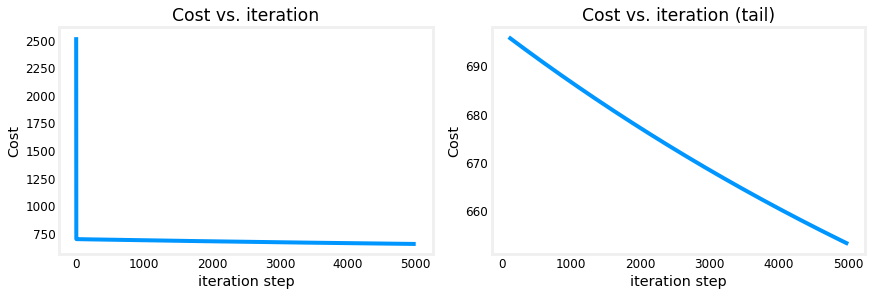

In [18]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

*These results are not inspiring*! Cost is still declining and our predictions are not very accurate. The next lab will explore how to improve on this.


<a name="toc_15456_6"></a>
# 6 Congratulations!
In this lab you:
- Redeveloped the routines for linear regression, now with multiple variables.
- Utilized NumPy `np.dot` to vectorize the implementations